# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `bill_depth_mm` using the other variables in the dataset.

**Dummify** all variables that require this.

In [35]:
pip install palmerpenguins

In [36]:
# Code Here
from plotnine import *
import pandas as pd
import numpy as np
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.metrics import *
import palmerpenguins
from palmerpenguins import load_penguins
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.neighbors import KNeighborsRegressor


penguins = load_penguins()
penguins.head()
penguins = penguins.dropna()
penguins = pd.get_dummies(penguins, drop_first=True)
penguins.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year,species_Chinstrap,species_Gentoo,island_Dream,island_Torgersen,sex_male
0,39.1,18.7,181.0,3750.0,2007,False,False,False,True,True
1,39.5,17.4,186.0,3800.0,2007,False,False,False,True,False
2,40.3,18.0,195.0,3250.0,2007,False,False,False,True,False
4,36.7,19.3,193.0,3450.0,2007,False,False,False,True,False
5,39.3,20.6,190.0,3650.0,2007,False,False,False,True,True


Let's use the other variables to predict `bill_depth_mm`. Prepare your data and fit the following models on the entire dataset:

* Your best multiple linear regression model from before
* Two kNN models (for different values of K)
* A decision tree model

Create a plot like the right plot of Fig 1. in our `Model Validation` chapter with the training and test error plotted for each of your four models.

Which of your models was best?

In [37]:
X = penguins.drop(columns=['bill_depth_mm'])
Y = penguins['bill_depth_mm']

#LR Pipeline
lr_pipeline = Pipeline(
  [('standardize', StandardScaler()),
  ('poly', PolynomialFeatures(degree=1, include_bias=False)),
  ('linear_regression', LinearRegression())]
)

#K Nearest Neighbors Pipeline
knn_pipeline = Pipeline(
  [('standardize', StandardScaler()),
  ('knn_regressor', KNeighborsRegressor())]
)

#Decision Tree Regressor Pipeline
dt_pipeline = Pipeline(
  [('standardize', StandardScaler()),
  ('decision_tree', DecisionTreeRegressor(random_state = 24))]
)

param_grid_lr = {
    'poly__degree': [1,2,3,4,5]
}

param_grid_knn = {
    'knn_regressor__n_neighbors': [3,5,7,9] #I used 4 models instead of 2 to get better results
}

param_grid_dt = {
    'decision_tree__max_depth': [2,3,4]
}

lr  = GridSearchCV(lr_pipeline,param_grid = param_grid_lr, scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1)
knn = GridSearchCV(knn_pipeline, param_grid = param_grid_knn, scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1)
dt  = GridSearchCV(dt_pipeline, param_grid = param_grid_dt, scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1)

lr.fit(X, Y)
knn.fit(X, Y)
dt.fit(X, Y)

lr_train_mse = -lr.cv_results_['mean_train_score'][lr.best_index_]
lr_cv_mse    = -lr.cv_results_['mean_test_score'][lr.best_index_]

# kNN
knn_train_mse = -knn.cv_results_['mean_train_score'][knn.best_index_]
knn_cv_mse    = -knn.cv_results_['mean_test_score'][knn.best_index_]

# Decision Tree
dt_train_mse = -dt.cv_results_['mean_train_score'][dt.best_index_]
dt_cv_mse    = -dt.cv_results_['mean_test_score'][dt.best_index_]

mse_table = pd.DataFrame({
    'Model': ['Linear Regression', 'kNN', 'Decision Tree'],
    'Train MSE': [lr_train_mse, knn_train_mse, dt_train_mse],
    'CV MSE': [lr_cv_mse, knn_cv_mse, dt_cv_mse]
})

print(mse_table)


#Decision tree is clearly the best model using the CV MSE as the evaluation metric
assert dt_cv_mse <= min(lr_cv_mse, knn_cv_mse) #if this runs it means Im right and the
#lowest CV MSE is decision trees, if it raises an error it means its not the lowest, and my
#code is wrong

best_estimator = dt.best_estimator_
best_params = dt.best_params_

print(f"Best model by CV MSE: Decision Tree(CV MSE = {dt_cv_mse:.4f})")
print("Best params:", best_params)
print("Best estimator pipeline:", best_estimator)


               Model  Train MSE    CV MSE
0  Linear Regression   0.578764  0.883216
1                kNN   0.516569  0.883416
2      Decision Tree   0.679153  0.759931
Best model by CV MSE: Decision Tree(CV MSE = 0.7599)
Best params: {'decision_tree__max_depth': 2}
Best estimator pipeline: Pipeline(steps=[('standardize', StandardScaler()),
                ('decision_tree',
                 DecisionTreeRegressor(max_depth=2, random_state=24))])


The best model is the Decision Tree model when max_depth = 2 as it has the lowest CV MSE

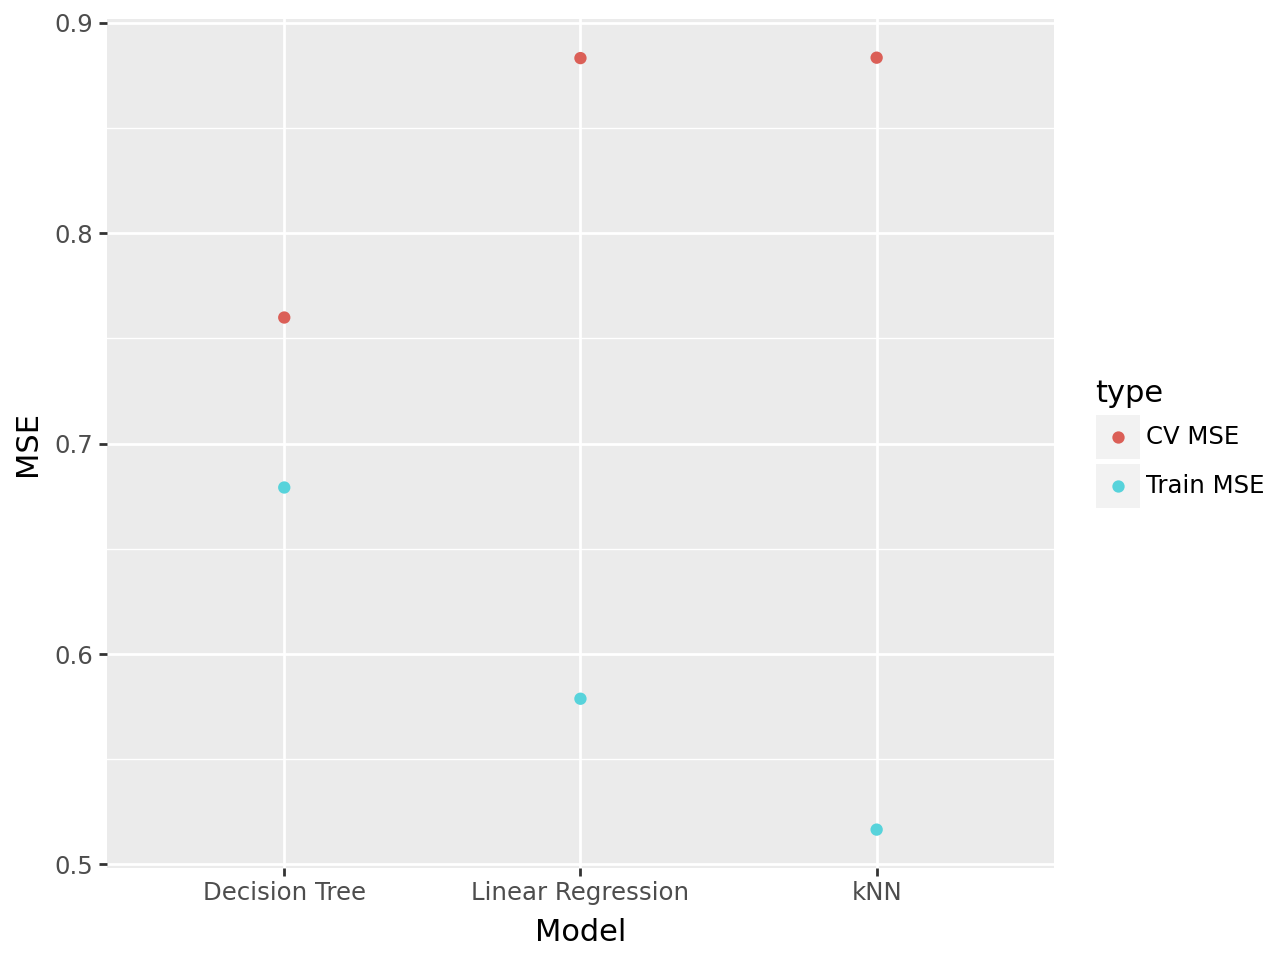

In [38]:
df_error_long = mse_table[["Model", "Train MSE", "CV MSE"]].melt(id_vars=["Model"], value_name = "MSE", var_name = "type")
df_error_long
(ggplot(df_error_long,
        aes(x = "Model",
            y = "MSE",
            color = "type")) +
 geom_point())